In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
dir_path = os.path.dirname(os.getcwd())

In [4]:
products = pd.read_csv(os.path.join(dir_path, 'data', 'raw', 'product.csv'))

In [5]:
df = pd.read_csv(os.path.join(dir_path, 'data', 'normalized_data.csv'))
df.head()

,id,visitorId,itemId,normalized_session_duration
0,0,50743654948546081-2,GGOEGAAX0031,0.120099
1,1,5342238128015433624-1,GGOEGAAX0031,0.122196
2,2,966739175376367480-2,GGOEGAAX0031,0.428319
3,3,8321419770612068321-1,GGOEGAAX0031,0.000883
4,4,4132865605127470100-1,GGOEGAAX0031,0.526131


# Split train and validation

In [65]:
# from sklearn.model_selection import train_test_split

In [66]:
# train, val = train_test_split(df , train_size=0.75,random_state=42)

In [68]:
# split train and validation before encoding
np.random.seed(3)
msk = np.random.rand(len(df)) < 0.8
train = df[msk].copy()
val = df[~msk].copy()

In [69]:
train.shape

(109803, 4)

In [70]:
val.shape

(27711, 4)

Assigning continous index Id's to visitor Id's and item Id's in training set, then mapping these index Id's to the visitor Id's and item id's in Valdation dataset. Also removing the visitor Id; which are not present in the training set

In [71]:
# Encodes a pandas column with continous ids.
def proc_col(col, train_col=None):
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [72]:
# Encodes rating data with continous user and movie ids. 
# If train is provided, encodes df with the same encoding as train.

def encode_data(df, train=None):
    df = df.copy()
    for col_name in ["visitorId", "itemId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [73]:
# encoding the train and validation data
df_train = encode_data(train)
df_val = encode_data(val, train)

In [74]:
df_train

,id,visitorId,itemId,normalized_session_duration
0,0,0,0,0.120099
1,1,1,0,0.122196
2,2,2,0,0.428319
3,3,3,0,0.000883
6,6,4,0,0.105259
...,...,...,...,...
137507,137507,32699,368,0.000110
137508,137508,51720,368,0.000110
137510,137510,51721,368,0.000110
137512,137512,51722,368,0.000110


In [75]:
df_val

,id,visitorId,itemId,normalized_session_duration
4,4,959,0,0.526131
5,5,21468,0,0.271865
29,29,2415,0,0.644244
30,30,1214,0,0.532586
33,33,23544,0,0.116624
...,...,...,...,...
137432,137432,48324,347,0.000110
137461,137461,11381,358,0.000110
137475,137475,18295,360,0.000110
137493,137493,20942,362,0.000110


In [89]:
## With VisitorId get visitor name (use visitor Id from the encoded data)
def get_userName(visitorId):
  visitor = (df_train[df_train['visitorId'] == visitorId]['id'].values)[0]
  customer = df[df['id'] == visitor]['visitorId'].values[0]
  return customer
get_userName(959)

'4132865605127470100-1'

In [113]:
## With ItemID get product name (use ItemId's from encoded data)
def get_itemName(itemId):
  itm = df_train[df_train['itemId'] == itemId]['id'].values[0]
  itm = df[df['id']== itm]['itemId'].values[0]
  itemId_name = dict(zip(products['itemId'], products['itemName']))
  return itemId_name[itm]
get_itemName(5)

"Google Men's Short Sleeve Badge Tee Charcoal"

In [114]:
### Items liked by user in train and val dataset 
### (use visitor Id from the encoded data and dataframe is encoded train and validation data)
def liked_items(visitorId, dataframe):
  likes = dataframe[dataframe['visitorId'] == visitorId]['itemId'].values.tolist()
  for i in likes:
    print(get_itemName(i))

liked_items(959, df_val)

Parker Gunmetal CT Ball Pen
Google Tote Bag
Waterpoof Gear Bag
YouTube Womens 3/4 Sleeve Baseball Raglan White/Black
PaperMate Ink Joy Retractable Pen
Google Women's Performance Full Zip Jacket Black


## Model

In [76]:
visitor_count = len(df_train['visitorId'].unique())
item_count = len(df_train['itemId'].unique())

In [126]:
visitors =  torch.LongTensor(df_train.visitorId.values)
items = torch.LongTensor(df_train.itemId.values)

In [127]:
## Every nn.Module subclass implements the operations on input data in the forward method
class MatrixMultiplication(nn.Module):      ## defining Matrix multiplication by subclassing nn.Module
  def __init__(self, visitor_count, item_count, embed_size = 100): 
    super(MatrixMultiplication, self).__init__()     ## Initialize matrix Multiplication using __init__ 
    self.visitor_embed = nn.Embedding(visitor_count, embed_size) ## feature embedding for visitor
    self.item_embed = nn.Embedding(item_count, embed_size)  ## feature embedding for items
    self.visitor_embed.weight.data.uniform_(0, 0.05)
    self.item_embed.weight.data.uniform_(0, 0.05)

  def forward(self, v, i):
    v = self.visitor_embed(v)
    i = self.item_embed(i)
    return (v*i).sum(1)   ### V*I gives the sparse matrix 

In [144]:
def training (model, epochs = 2, lr = 0.001, wd = 0.0, unsqueeze = False):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
  model.train()
  train_loss = []
  val_loss = []
  for i in range(epochs):
    print("----------Epoch {}----------".format(i+1))
    visitors = torch.LongTensor(df_train.visitorId.values)
    items = torch.LongTensor(df_train.itemId.values)
    session_duration = torch.FloatTensor(df_train.normalized_session_duration.values)
    # print(session_duration.dtype)
    if unsqueeze:
      session_duration.unsqueeze(1)
    out = model(visitors, items)
    # print(y_hat.dtype)
    loss = F.mse_loss(out, session_duration)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    val_loss.append(testing(model, unsqueeze))
    print("Train loss : {}".format(loss.item()))
    print("Val loss : {}\n".format(testing(model, unsqueeze)))
  return train_loss, val_loss

In [145]:
def testing(model, unsqueeze = False):
  model.eval()
  visitors = torch.LongTensor(df_val.visitorId.values)
  items = torch.LongTensor(df_val.itemId.values)
  session_duration = torch.FloatTensor(df_val.normalized_session_duration.values)
  if unsqueeze :
    session_duration.unsqueeze(1)
  out = model(visitors, items)
  loss = F.mse_loss(out , session_duration)
#   print("Test loss ; {}".format(loss.item()))
  return loss.item()




In [153]:
model = MatrixMultiplication(visitor_count, item_count)
model

MatrixMultiplication(
  (visitor_embed): Embedding(51724, 100)
  (item_embed): Embedding(372, 100)
)

In [154]:
epochs=5
train_loss, val_loss = training(model, epochs, lr=0.01)

----------Epoch 1----------
Train loss : 0.26514527201652527
Val loss : 0.234284445643425

----------Epoch 2----------
Train loss : 0.22563667595386505
Val loss : 0.19627299904823303

----------Epoch 3----------
Train loss : 0.1818234920501709
Val loss : 0.16449744999408722

----------Epoch 4----------
Train loss : 0.1401776373386383
Val loss : 0.14621411263942719

----------Epoch 5----------
Train loss : 0.10737169533967972
Val loss : 0.14475426077842712



### Plot training and validation loss

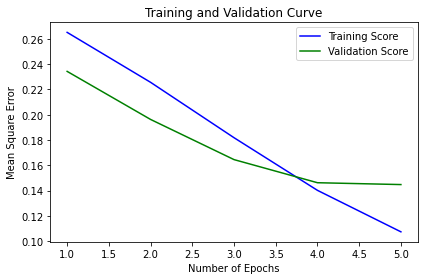

In [155]:
parameter_range = np.arange(1, epochs+1, 1)
plt.plot(parameter_range, train_loss, 
     label = "Training Score", color = 'b')
plt.plot(parameter_range, val_loss ,
   label = "Validation Score", color = 'g')
# Creating the plot
plt.title("Training and Validation Curve")
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Square Error")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [163]:
m = 959   ## visitor at index 1
n = 5     ## Item at index 0
a = torch.LongTensor([m]) 
b = torch.LongTensor([n])  

In [164]:
model.eval()
with torch.no_grad():
  out = model(a, b)
print(out)

tensor([0.4248])


In [161]:
get_userName(m)

'4132865605127470100-1'

In [158]:
get_itemName(n)

"Google Men's Short Sleeve Badge Tee Charcoal"

In [159]:
liked_items(m, df_train)  ### liked items from training

Google Sunglasses
Android Men's Long Sleeve Badge Crew Tee Heather
Google Toddler Short Sleeve T-shirt Royal Blue
Softsided Travel Pouch Set
Ballpoint Pen Blue
Google Long Sleeve Raglan Badge Henley Ocean Blue
Google Women's Short Sleeve Performance Tee Black
Android Twill Cap
Google Luggage Tag
Gift Card- $100.00
Google Women's Zip Hoodie Grey
Google Ballpoint Pen Black
Suitcase Organizer Cubes
Recycled Mouse Pad
Windup Android
Yoga Mat
Keyboard DOT Sticker


In [162]:
liked_items(m, df_val)  ### Liked items from validation set

Parker Gunmetal CT Ball Pen
Google Tote Bag
Waterpoof Gear Bag
YouTube Womens 3/4 Sleeve Baseball Raglan White/Black
PaperMate Ink Joy Retractable Pen
Google Women's Performance Full Zip Jacket Black
